In [242]:
import pandas as pd; import numpy as np 
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import joblib

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [197]:
df = pd.read_csv("00_Data/processed_data.csv")
df_norm = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
le = LabelEncoder()

In [189]:
df_norm.head()

,age,bmi,children,expenses,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.345930,0.0,0.267626,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.517442,0.2,0.010249,1.0,0.0,0.0,0.0,1.0,0.0
2,0.326087,0.194767,0.0,0.354207,1.0,0.0,0.0,1.0,0.0,0.0
3,0.304348,0.375000,0.0,0.046605,1.0,0.0,0.0,1.0,0.0,0.0
4,0.282609,0.281977,0.0,0.044733,0.0,0.0,0.0,0.0,1.0,0.0


Create a new categorical feature 'expenses' based on quartiles

In [198]:
expense_labels = ['low', 'medium', 'high']

df_norm['expenses'] = pd.qcut(df_norm['expenses'], q=3, labels=expense_labels)

# Print the first few rows to verify the new feature
print(df_norm.head())

        age       bmi  children expenses  sex_male  smoker_yes  \
0  0.021739  0.345930       0.0     high       0.0         1.0   
1  0.000000  0.517442       0.2      low       1.0         0.0   
2  0.326087  0.194767       0.0     high       1.0         0.0   
3  0.304348  0.375000       0.0      low       1.0         0.0   
4  0.282609  0.281977       0.0      low       0.0         0.0   

   region_northeast  region_northwest  region_southeast  region_southwest  
0               0.0               0.0               0.0               1.0  
1               0.0               0.0               1.0               0.0  
2               0.0               1.0               0.0               0.0  
3               0.0               1.0               0.0               0.0  
4               0.0               0.0               1.0               0.0  


In [109]:
expenses_count = df_norm['expenses'].value_counts(normalize=True)
print(expenses_count)

low       0.333333
medium    0.333333
high      0.333333
Name: expenses, dtype: float64


In [199]:
X = df_norm.drop('expenses', axis=1)
y = df_norm['expenses']

y = le.fit_transform(y)



0         high
1          low
2         high
3          low
4          low
         ...  
1327    medium
1328       low
1329       low
1330       low
1331      high
Name: expenses, Length: 1332, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']


array([0, 1, 0, ..., 1, 1, 0])

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=21)

### 01) Decision Tree Classification 




#### Parameters for tuning a Decision Tree Classifier 

**criterion**: This parameter specifies the function that is used to measure the quality of a split. The default value is *gini* for classification problems and *mse* for regression problems. Other options include *entropy* for classification problems and *friedman_mse* for regression problems.

- Classification
    * '*gini*' : This is a measure $\left(1 - \sum_{j} p_{j}^{2}\right)$ of how often a randomly chosen element from a set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. It ranges from 0 to 0.5, 0 value happens when the node is pure, this means that all the contained elements in the node are of one unique class. Thus, the optimum split is chosen by the features with less Gini Index. Moreover, it gets the maximum value when the probability of the two classes are the same with gini value of 0.5.
    * '*entropy*' :  This is a measure $\left(-\sum_{j} p_{j}log_{2}(p_{j})\right)$ of the amount of uncertainty in a set. It is based on the concept of information entropy from information theory. In the context of decision trees, entropy measures the impurity or randomness of a subset of data. It ranges from 0 to 1, where a value of 0 means that all elements in the subset belong to the same class, and a value of 1 means that the elements are equally distributed among all classes.

Gini impurity is preferred when the classes are well-balanced, while entropy is more useful when the classes are imbalanced. Computationally, entropy is more complex since it makes use of logarithms and consequently, the calculation of the Gini Index will be faster.


**splitter**: This parameter specifies the strategy used to choose the split at each node. The default value is '*best*', which means that the best split is chosen based on the criterion specified. Another option is *random*, which means that a random split is chosen.

**max_depth**: This parameter specifies the maximum depth of the tree. The default value is "None", which means that nodes are expanded until all the leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_split**: This parameter specifies the minimum number of samples required to split an internal node. The default value is 2, meaning that a split is only performed if there are at least two samples in each resulting subset.

**min_samples_leaf**: This parameter specifies the minimum number of samples required to be at a leaf node. The default value is 1, meaning that each leaf will contain at least one sample.

**max_features**: This parameter specifies the maximum number of features to consider when looking for the best split. The default value is *None*, which means that all features are considered.

**max_leaf_nodes**: This parameter specifies the maximum number of leaf nodes in the tree. The default value is "None", which means that there is no limit on the number of leaf nodes.

**min_impurity_decrease**: This parameter specifies the minimum amount of impurity decrease required to split a node. The default value is 0, meaning that any split that reduces impurity is considered.

#### Using Cross-validation to find the best parameter set for the Decision Tree Model

Cross-validation is a useful technique for evaluating the performance of a predictive model because it provides an estimate of how well the model will generalize to new data. The basic idea behind cross-validation is to split the dataset into two or more parts: a training set, which is used to train the model, and a validation set, which is used to evaluate the performance of the model. The validation set is typically a small subset of the original dataset, and it is used to estimate the error rate of the model.

Typed of cross-validation: 

- **k-Fold Cross-Validation**: In k-fold cross-validation, the dataset is divided into k equal-sized parts, or "folds". The model is trained on k-1 of the folds, and the remaining fold is used for validation. This process is repeated k times, with each fold used once for validation. The results of the k validation tests are then averaged to produce an estimate of the model's performance.

- **Leave-One-Out Cross-Validation**: In leave-one-out cross-validation, the dataset is divided into n parts, where n is the number of samples in the dataset. For each validation test, one sample is held out as the validation set, and the remaining samples are used to train the model. This process is repeated n times, with each sample used once for validation.

- **Stratified Cross-Validation**: Stratified cross-validation is a variation of k-fold cross-validation that ensures that each fold contains roughly the same proportion of samples from each class.

Here we use the **k-Fold Cross Validation** with k=5. 


{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 7}
Accuracy:  0.9009009009009009


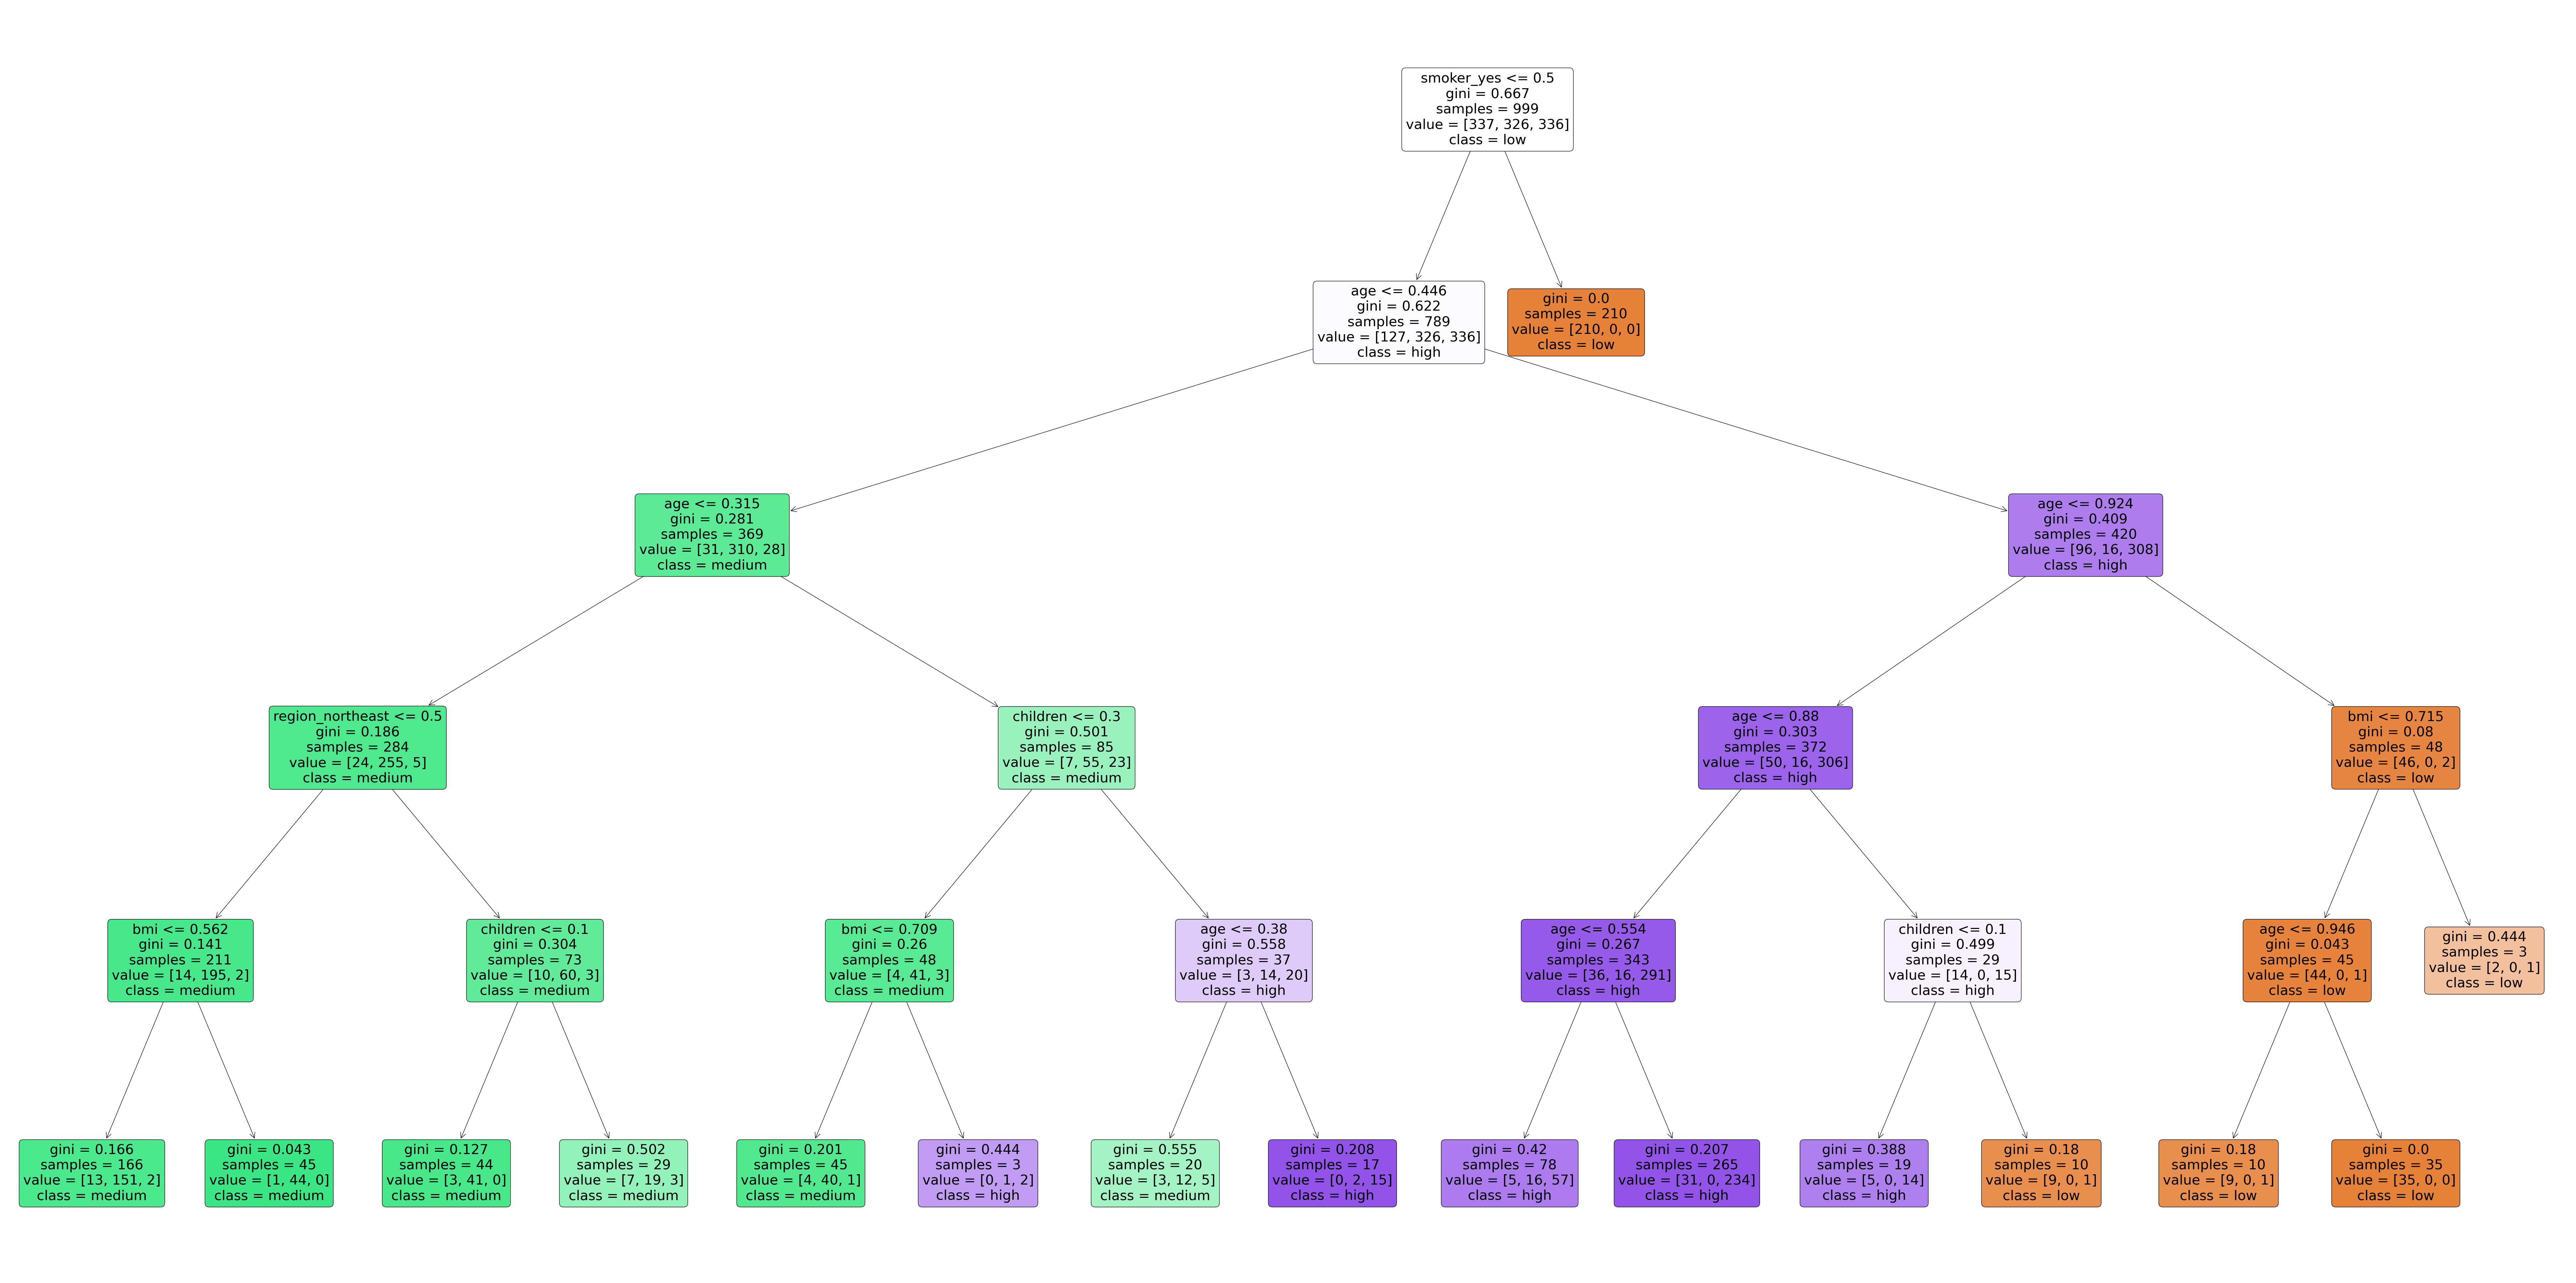

In [243]:
# Perform hyperparameter tuning with cross-validation
param_grid = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5,7, 10],
    'min_samples_leaf': [1,3,5,7],
    'max_features': ['sqrt', 'log2', None]
}

dt_model = DecisionTreeClassifier(random_state=21)
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best combination of hyperparameters
best_params = grid_search.best_params_
print (best_params)

# Train the final decision tree model
best_dt_model = DecisionTreeClassifier(**best_params ,random_state=21)
best_dt_model.fit(X_train, y_train)

# a confusion matrix 
y_pred = best_dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Save the model 
joblib.dump(best_dt_model, "00_Data/01_Classification_models/dt_model.joblib")

fig, ax = plt.subplots(figsize=(100, 50))
tree.plot_tree(best_dt_model, feature_names=X.columns, class_names=['low', 'medium', 'high'], filled=True, rounded=True, ax=ax)
 
plt.show()

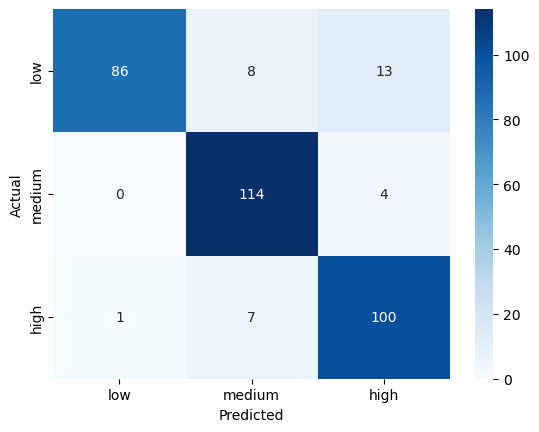

Accuracy: 0.9009009009009009
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       107
           1       0.88      0.97      0.92       118
           2       0.85      0.93      0.89       108

    accuracy                           0.90       333
   macro avg       0.91      0.90      0.90       333
weighted avg       0.91      0.90      0.90       333



In [202]:
# Create the confusion matrix 
y_pred = best_dt_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate the accuracy and print the classification report
accuracy = accuracy_score(y_test, y_pred)

# ANSI escape codes for bold and green color in print (optional)
bold = "\033[1m"
green = "\033[32m"
reset = "\033[0m"

print(f"{bold}{green}Accuracy: {accuracy}{reset}")

print(classification_report(y_test, y_pred))

age                 0.601556
smoker_yes          0.356434
children            0.034327
bmi                 0.005868
region_northeast    0.001815
sex_male            0.000000
region_northwest    0.000000
region_southeast    0.000000
region_southwest    0.000000
dtype: float64


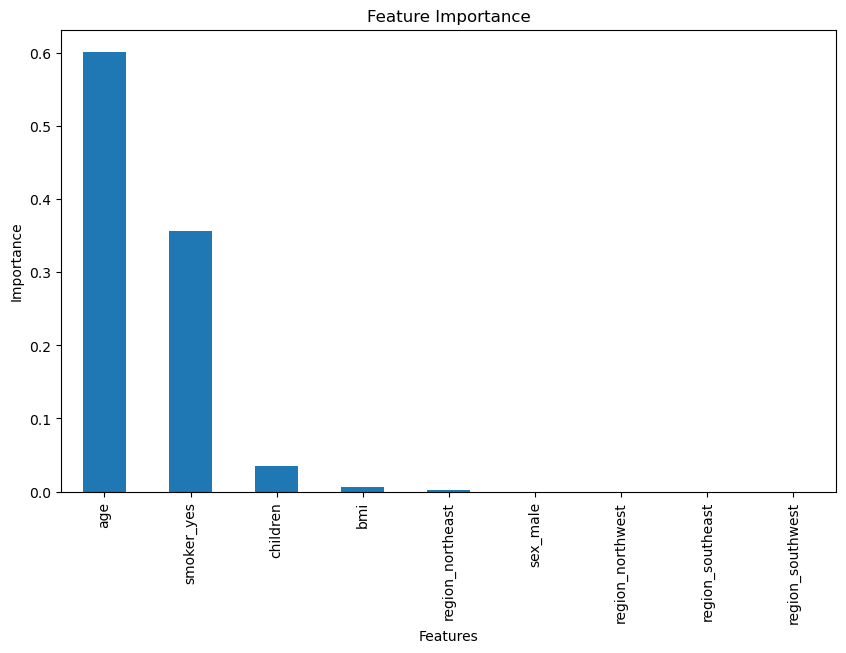

In [203]:
# Get feature importances from the decision tree model
feature_importances = best_dt_model.feature_importances_

# Create a pandas Series with the feature importances and the column names
importances = pd.Series(feature_importances, index=X.columns)

# Sort the importances in descending order

sorted_importances = importances.sort_values(ascending=False)
print (sorted_importances)

# Plot the feature importances

plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='bar')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()

In [204]:
cumulative_sum_imp = np.cumsum(sorted_importances)
sel_features = cumulative_sum_imp[cumulative_sum_imp<0.999].index.tolist()
X_sel = X[sel_features]

X_sel_train, X_sel_test, y_train, y_test = train_test_split(X_sel, y,random_state=21)
print ("Selected Features: {}".format(sel_features))

Selected Features: ['age', 'smoker_yes', 'children', 'bmi']


### Pruning Decision Trees based on Cost Complexity 

Cost complexity pruning is a method used to prevent overfitting in decision trees by reducing the size of the tree. The idea behind cost complexity pruning is to add a regularization term to the tree-building process that penalizes the size of the tree.

The cost complexity formula used in cost complexity pruning is: 
$R(T) = R(T_0) + α|T|$

where R(T) is the total cost of the tree T, R(T_0) is the cost of the tree with only the root node, |T| is the number of leaf nodes in the tree T, and α is a non-negative scalar known as the complexity parameter. If we only try to reduce the training error R(T), it will lead to relatively larger trees (more leaf nodes), resulting in overfitting. 

The parameter α reduces the complexity of the tree by controlling the number of leaf nodes, which eventually reduces over-fitting. Which subtree is selected eventually depends on α . If α=0, then the biggest tree will be chosen because the complexity penalty term is essentially dropped. As α approaches infinity, the tree of size 1, i.e., a single root node, will be selected.

Using cross-validation of 5 folds we find the best alpha value for the cost-complexity parameter. 

In [205]:
path = best_dt_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Use cross-validation to find the best ccp_alpha
scores = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=0)
    score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    scores.append(score)

# Get the optimal alpha value
best_alpha = ccp_alphas[np.argmax(scores)]
print ("Best alpha: ", best_alpha)

# Train the final decision tree model
best_clf = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=0)
best_clf=best_clf.fit(X_train, y_train)


# a confusion matrix 
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: ", accuracy)

Best alpha:  0.00531965722528336
Accuracy:  0.8888888888888888


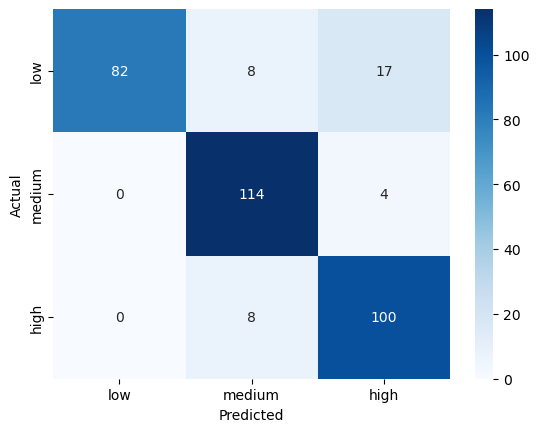

In [206]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 02) SVM Classification 

#### Parameters for tuning a SVM Classifier 

* **C** : The C parameter controls the trade-off between achieving a low training error and a low testing error. It determines the penalty for misclassifying a training example. A smaller C value results in a wider margin and more margin violations, while a larger C value results in a narrower margin and fewer margin violations.

* **kernel** : The kernel parameter specifies the kernel function used to transform the input data into a higher-dimensional feature space. Some commonly used kernel functions include the linear kernel, polynomial kernel, and radial basis function (RBF) kernel. The choice of kernel depends on the structure of the data and the complexity of the decision boundary.

* **gamma** : The gamma parameter controls the shape of the decision boundary. A smaller gamma value results in a more flexible decision boundary that can capture complex patterns in the data, while a larger gamma value results in a simpler decision boundary that is less prone to overfitting.

* **degree** : The degree parameter specifies the degree of the polynomial kernel function. It is only used when the kernel parameter is set to *'poly'*. A higher degree value can capture more complex polynomial patterns in the data but can also lead to overfitting.

* **coef0** : The coef0 parameter controls the independent term in the kernel function. It is only used when the kernel parameter is set to *'poly'* or *'sigmoid'*. A higher coef0 value can increase the model's capacity to fit the data but can also increase the risk of overfitting.

* **shrinking** : The shrinking parameter controls whether to use the shrinking heuristic in the SVM algorithm. The shrinking heuristic can speed up the training process by skipping some of the samples that are far away from the decision boundary. By default, shrinking is set to *True*.

* **tol** : The tol parameter specifies the tolerance for stopping criterion. The SVM algorithm stops when the change in the objective function is smaller than tol. A smaller tol value can lead to more accurate results but can also increase the training time.

* **class_weight** : The class_weight parameter is used to handle imbalanced datasets. It assigns a weight to each class to balance the contribution of different classes to the objective function. By default, class_weight is set to *None*, meaning that all classes have equal weight.

In [244]:
from sklearn.svm import SVC

# Define the SVM classifier
svm = SVC()

# Define the hyperparameter grid for tuning
param_grid = {'C': [0.1, 1, 10, 50, 75, 100],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': ['scale','auto'],
              'degree': [1,2,3,5,7]}

# Perform a grid search to find the best hyperparameters
grid_search = GridSearchCV(svm, param_grid, cv=8)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters: ", grid_search.best_params_)

svm = SVC(**grid_search.best_params_)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

joblib.dump(svm, "00_Data/01_Classification_models/svm_model.joblib")

# Evaluate the SVM classifier on the testing set
accuracy = svm.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

Best hyperparameters:  {'C': 50, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy: 89.79%


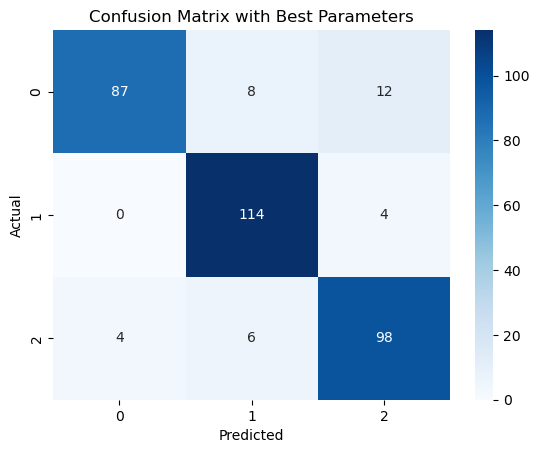

In [208]:
# Plot the confusion matrix
cm_svm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix with Best Parameters")
plt.show()

#### Using PCA to reduce the dimensions of the data 

In [209]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


# Define the hyperparameter grid for tuning
param_grid = {'C': [0.1, 1, 10, 50, 75, 100],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': ['scale','auto'],
              'degree': [1,2,3,5,7]}

# Perform a grid search to find the best hyperparameters
grid_search = GridSearchCV(svm, param_grid, cv=8)
grid_search.fit(X_train_pca, y_train)

# Print the best hyperparameters found
print("Best hyperparameters: ", grid_search.best_params_)

svm = SVC(**grid_search.best_params_)
svm.fit(X_train_pca, y_train)

y_pred = svm.predict(X_test_pca)

# Evaluate the SVM classifier on the testing set
accuracy = svm.score(X_test_pca, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))



Best hyperparameters:  {'C': 100, 'degree': 7, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy: 82.58%


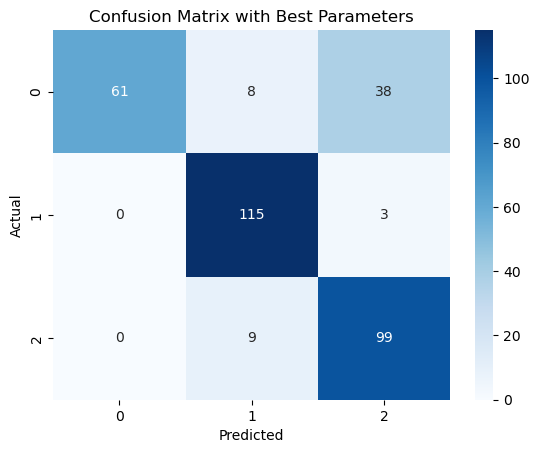

In [172]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix with Best Parameters")
plt.show()

We found that using PCA with SVA did not perform well as expected compared to the one without using any PCA components. 

### 03) Random Forest Classifier 

In [245]:
from sklearn.ensemble import RandomForestClassifier

# Define the random forest classifier
rfc = RandomForestClassifier(random_state=42)


# Define the hyperparameter grid for tuning
param_grid = {'n_estimators': [50, 100, 200], 
              'max_depth': [3, 5, 7, 9, None],
              'min_samples_split': [2, 5, 7, 10],
              'min_samples_leaf': [1,3,5,7],
              'max_features': ['sqrt', 'log2', None]}

# Perform a grid search to find the best hyperparameters
grid_search = GridSearchCV(rfc, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

rfc = RandomForestClassifier(random_state=42, **grid_search.best_params_)
rfc.fit(X_train, y_train)

joblib.dump(rfc, "00_Data/01_Classification_models/rfc_model.joblib")

y_pred = rfc.predict(X_test)

accuracy = rfc.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

Best hyperparameters:  {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 90.99%


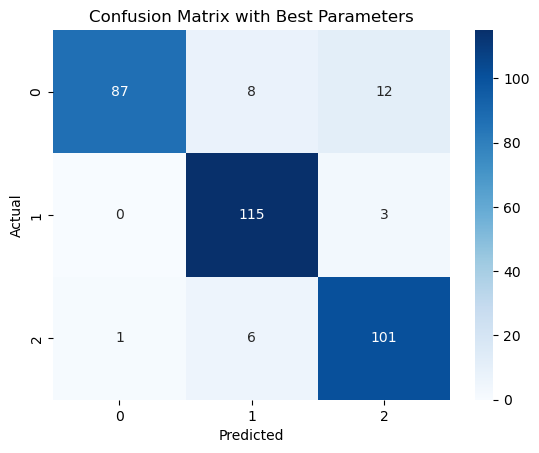

In [246]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix with Best Parameters")
plt.show()

### 04) Deep Neural Network 

We use a callback function 'EarlyStopping()' that stops the training process when a monitored metric has stopped improving for a specified number of epochs. This can help prevent overfitting and save time by stopping the training process early if the model has already converged. The *patience* parameter specifies the number of epochs to wait before stopping the training process if the monitored metric does not improve. In this case, if the validation loss does not improve for 5 consecutive epochs, the training process will stop while the *monitor* parameter specifies the metric to monitor for improvement. In this case, we are monitoring the validation loss, which is the loss calculated on a validation set during training. The *restore_best_weights*=True specifies whether to restore the weights of the model to the best state observed during training. If set to True, the weights of the model will be set to the best state observed during training when the training process stops. This can help prevent overfitting and improve the generalization performance of the model.

In [247]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(400, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(600, activation='relu'),
    tf.keras.layers.Dense(600, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='00_Data/01_Classification_models/nn_clf.h5', save_best_only=True)

# Define early stopping callback
early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=300,  batch_size=100, validation_data=(X_test, y_test),verbose=1,callbacks=[checkpoint_callback,early_stop])


# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print('Test accuracy:', test_acc)

Epoch 1/300
10/10 [==============================] - 1s 43ms/step - loss: 0.8436 - accuracy: 0.5966 - val_loss: 0.5516 - val_accuracy: 0.8138
Epoch 2/300
10/10 [==============================] - 1s 69ms/step - loss: 0.5047 - accuracy: 0.8088 - val_loss: 0.4261 - val_accuracy: 0.8288
Epoch 3/300
10/10 [==============================] - 1s 98ms/step - loss: 0.4200 - accuracy: 0.8549 - val_loss: 0.4114 - val_accuracy: 0.8649
Epoch 4/300
10/10 [==============================] - 1s 96ms/step - loss: 0.3700 - accuracy: 0.8709 - val_loss: 0.3925 - val_accuracy: 0.8679
Epoch 5/300
10/10 [==============================] - 0s 18ms/step - loss: 0.3658 - accuracy: 0.8699 - val_loss: 0.3929 - val_accuracy: 0.8799
Epoch 6/300
10/10 [==============================] - 1s 102ms/step - loss: 0.3798 - accuracy: 0.8609 - val_loss: 0.3710 - val_accuracy: 0.8529
Epoch 7/300
10/10 [==============================] - 1s 105ms/step - loss: 0.3692 - accuracy: 0.8549 - val_loss: 0.3542 - val_accuracy: 0.8949
Epoc

Text(0.5, 1.0, 'Confusion Matrix')

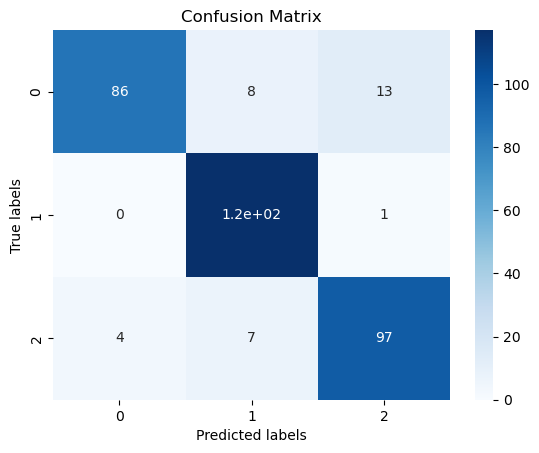

In [248]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Set the plot labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')